# EX4 - 작사가 인공지능 만들기

****************************

#### mkdir -p ~/aiffel/lyricist/models
#### ln -s ~/data ~/aiffel/lyricist/data

#### 파일 준비

In [10]:
import re
import numpy as np
import tensorflow as tf
import glob
import os

from sklearn.model_selection import train_test_split

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3]) # 문장 3개 확인

데이터 크기: 187088
Examples:
 [' There must be some kind of way outta here', 'Said the joker to the thief', "There's too much confusion"]


****************
## 문장 전처리

### 문장들을 정규표현식을 이용해서 정제

In [11]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 소문자로 바꾸고 양쪽 공백을 삭제
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 패턴의 특수문자를 만나면 특수문자 양쪽에 공백을 추가
    sentence = re.sub(r'[" "]+', " ", sentence) # 공백 패턴을 만나면 스페이스 1개로 치환
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # a-zA-Z?.!,¿ 패턴을 제외한 모든 문자(공백문자까지도)를 스페이스 1개로 치환
    

    sentence = sentence.lower().strip()
    

    sentence = '<start> ' + sentence + ' <end>' # 문장 앞뒤로 <start>와 <end>를 단어처럼 붙여 줍니다

    return sentence

print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


In [12]:
corpus = []
for idx, sentence in enumerate(raw_corpus):
    # 아무것도 들어 있지 않은 문장 제외
    if len(sentence) == 0 : continue
    if sentence[-1] == ":": continue 
    # 데이터로 사용한 글의 종류가 대본일 경우 비어있거나, 화자의 이름이 있을 경우에 사용.
    
    preprocessed_sentence = preprocess_sentence(sentence)
    # 정제후 단어의 개수가 13개를 넘는 문장 제외
    if not ( preprocessed_sentence.count(' ')+1 <= 15) : continue
    # corpus에 이미 등록되어 있는 경우는 건너뜀
    if preprocessed_sentence in corpus : continue
    corpus.append(preprocessed_sentence)
    
corpus[:10]

['<start> there must be some kind of way outta here <end>',
 '<start> said the joker to the thief <end>',
 '<start> there s too much confusion <end>',
 '<start> i can t get no relief business men , they drink my wine <end>',
 '<start> plowman dig my earth <end>',
 '<start> none were level on the mind <end>',
 '<start> nobody up at his word <end>',
 '<start> hey , hey no reason to get excited <end>',
 '<start> the thief he kindly spoke <end>',
 '<start> there are many here among us <end>']

**************
## 텐서 플로우를 활용한 데이터 토큰화

### 데이터를 숫자로 만드는 것을 벡터화
### 숫자로 변환된 데이터를 텐서

In [13]:
def tokenize(corpus):
    # 텐서플로우에서 제공하는 Tokenizer 패키지를 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000,   # 전체 단어의 개수 
        filters=' ',      # 전처리 로직
        oov_token="<unk>" # out-of-vocabulary, 사전에 없는 단어
    )
    tokenizer.fit_on_texts(corpus) # 우리가 구축한 corpus로부터 Tokenizer가 사전을 자동구축

    # tokenizer를 활용하여 모델에 입력할 데이터셋을 구축
    tensor = tokenizer.texts_to_sequences(corpus) # tokenizer는 구축한 사전으로부터 corpus를 해석해 Tensor로 변환

    # 입력 데이터의 시퀀스 길이를 일정하게 맞추기 위한 padding  메소드
    # maxlen의 디폴트값은 None. corpus의 가장 긴 문장을 기준으로 시퀀스 길이가 맞춰진다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen = 15)  

    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

print(tensor[:3, :10]) # 텐서 데이터 확인

[[  2  59 231 ...   0   0   0]
 [  2 111   6 ...   0   0   0]
 [  2  59  15 ...   0   0   0]
 ...
 [  2  79  45 ...   3   0   0]
 [  2  57   4 ...   0   0   0]
 [  2  13 547 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7fd8aa19ae50>
[[   2   59  231   27   92  480   18   88  810   93]
 [   2  111    6 4850   10    6 1928    3    0    0]
 [   2   59   15  106  180 2243    3    0    0    0]]


In [14]:
# 단어 사전의 index
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break
# 1번 부터 저장된 문장 성분의 단어들을 확인 가능.

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


**********
## data 분리

In [15]:
src_input = tensor[:, :-1] 
tgt_input = tensor[:, 1:]

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size = 0.2, random_state = 2)
enc_val_train, enc_val_val, dec_val_train, dec_val_val = train_test_split(enc_train, dec_train, test_size = 0.125 , random_state = 2) 

print('Shape of Source :', enc_train.shape)
print('Shape of Target :', dec_train.shape)

Shape of Source : (80631, 14)
Shape of Target : (80631, 14)


In [16]:
print(src_input[:3])
print(tgt_input[:3])

[[   2   59  231   27   92  480   18   88  810   93    3    0    0    0]
 [   2  111    6 4850   10    6 1928    3    0    0    0    0    0    0]
 [   2   59   15  106  180 2243    3    0    0    0    0    0    0    0]]
[[  59  231   27   92  480   18   88  810   93    3    0    0    0    0]
 [ 111    6 4850   10    6 1928    3    0    0    0    0    0    0    0]
 [  59   15  106  180 2243    3    0    0    0    0    0    0    0    0]]


In [17]:
BUFFER_SIZE = len(enc_val_train)
BATCH_SIZE = 256
steps_per_epoch = BATCH_SIZE // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1 # 0:<pad>를 포함하여 dictionary 갯수 + 1


dataset = tf.data.Dataset.from_tensor_slices((enc_train,dec_train))
dataset = tf.data.Dataset.from_tensor_slices((enc_val_train, dec_val_train))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

### 모델 구조 정의

In [18]:
# 모델 생성
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
    
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        
        self.linear = tf.keras.layers.Dense(vocab_size)

    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)

        return out

embedding_size = 256 # 단어 하나의 특징 수
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [19]:
for src_sample, tgt_sample in dataset.take(1): break

In [20]:
model(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[ 3.04724763e-05,  6.42983578e-05, -5.24280113e-05, ...,
          1.79902927e-04,  3.15213430e-04,  3.87267588e-04],
        [ 7.78415633e-05,  7.93096387e-06, -3.63797844e-05, ...,
          3.11943382e-04,  1.70196290e-04,  5.61747758e-04],
        [-2.31193641e-04,  1.28585423e-04,  1.07717380e-04, ...,
          3.66382184e-04, -1.72122760e-04,  3.27562389e-04],
        ...,
        [-1.23449694e-03, -1.08415283e-04,  1.06592837e-03, ...,
          6.25685323e-04, -7.47497717e-04, -1.20544930e-04],
        [-1.07775186e-03, -9.22957327e-07,  1.03589089e-03, ...,
          5.65408205e-04, -6.89357636e-04, -3.67800269e-04],
        [-8.42045003e-04, -7.25029386e-05,  9.78066819e-04, ...,
          5.81545988e-04, -3.70055233e-04, -7.32951914e-04]],

       [[ 3.04724763e-05,  6.42983578e-05, -5.24280113e-05, ...,
          1.79902927e-04,  3.15213430e-04,  3.87267588e-04],
        [ 2.10424783e-04,  2.36041829e-04,  1

In [21]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  3072256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


In [22]:
optimizer = tf.keras.optimizers.Adam()
# optimizer = tf.keras.optimizers.SGD()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [23]:
model.compile(loss=loss, optimizer=optimizer)

# 다섯번째

In [27]:
history = model.fit(x = enc_train, y = dec_train, epochs=10, batch_size=64, validation_data = (enc_val_val, dec_val_val))

Epoch 1/10
1260/1260 [==============================] - 142s 113ms/step - loss: 2.9416 - val_loss: 2.8902
Epoch 2/10
1260/1260 [==============================] - 143s 113ms/step - loss: 2.9127 - val_loss: 2.8365
Epoch 3/10
1260/1260 [==============================] - 143s 113ms/step - loss: 2.8553 - val_loss: 2.7611
Epoch 4/10
1260/1260 [==============================] - 143s 113ms/step - loss: 2.7793 - val_loss: 2.6688
Epoch 5/10
1260/1260 [==============================] - 143s 113ms/step - loss: 2.6933 - val_loss: 2.5753
Epoch 6/10
1260/1260 [==============================] - 142s 113ms/step - loss: 2.6015 - val_loss: 2.4713
Epoch 7/10
1260/1260 [==============================] - 142s 113ms/step - loss: 2.5074 - val_loss: 2.3764
Epoch 8/10
1260/1260 [==============================] - 143s 113ms/step - loss: 2.4138 - val_loss: 2.2787
Epoch 9/10
1260/1260 [==============================] - 142s 113ms/step - loss: 2.3224 - val_loss: 2.1887
Epoch 10/10
1260/1260 [=======================

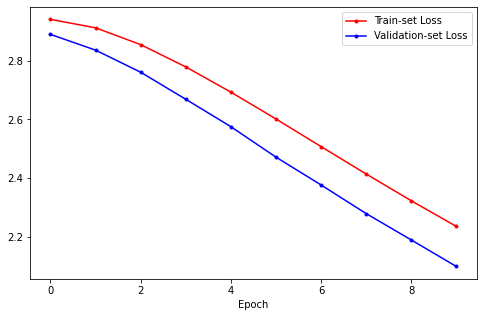

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(history.history['loss'], marker='.', c='red', label='Train-set Loss')
plt.plot(history.history['val_loss'], marker='.', c='blue', label='Validation-set Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [29]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=15):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [30]:
generate_text(model, tokenizer, init_sentence="<start> life")

'<start> life is a <unk> reminder of possibilities <end> '

In [31]:
generate_text(model, tokenizer, init_sentence="<start> kill")

'<start> kill me and i m not alone <end> '

In [32]:
generate_text(model, tokenizer, init_sentence="<start> cut")

'<start> cut me down <end> '

In [33]:
generate_text(model, tokenizer, init_sentence="<start> time")

'<start> time to be a <unk> <end> '

In [34]:
generate_text(model, tokenizer, init_sentence="<start> smoke")

'<start> smoke a <unk> , a <unk> <end> '

In [35]:
generate_text(model, tokenizer, init_sentence="<start> god")

'<start> god damn , i m a <unk> <end> '

In [36]:
generate_text(model, tokenizer, init_sentence="<start> girlfriend")

'<start> girlfriend , you re amazing <end> '

In [37]:
generate_text(model, tokenizer, init_sentence="<start> road")

'<start> road block <end> '

In [38]:
generate_text(model, tokenizer, init_sentence="<start> movie")

'<start> movie , euphoria <end> '

## ??? loss는 낮은데 문장 생성이 어색하다.
*************************
# 네번째

In [25]:
history = model.fit(x = enc_train, y = dec_train, epochs=10, batch_size=1024, validation_data = (enc_val_val, dec_val_val))

Epoch 1/10
79/79 [==============================] - 96s 1s/step - loss: 5.5374 - val_loss: 3.6818
Epoch 2/10
79/79 [==============================] - 93s 1s/step - loss: 3.6050 - val_loss: 3.4783
Epoch 3/10
79/79 [==============================] - 93s 1s/step - loss: 3.4506 - val_loss: 3.3299
Epoch 4/10
79/79 [==============================] - 94s 1s/step - loss: 3.3121 - val_loss: 3.2288
Epoch 5/10
79/79 [==============================] - 94s 1s/step - loss: 3.2137 - val_loss: 3.1625
Epoch 6/10
79/79 [==============================] - 94s 1s/step - loss: 3.1555 - val_loss: 3.0981
Epoch 7/10
79/79 [==============================] - 94s 1s/step - loss: 3.0943 - val_loss: 3.0471
Epoch 8/10
79/79 [==============================] - 94s 1s/step - loss: 3.0484 - val_loss: 3.0024
Epoch 9/10
79/79 [==============================] - 94s 1s/step - loss: 2.9971 - val_loss: 2.9625
Epoch 10/10
79/79 [==============================] - 94s 1s/step - loss: 2.9654 - val_loss: 2.9245


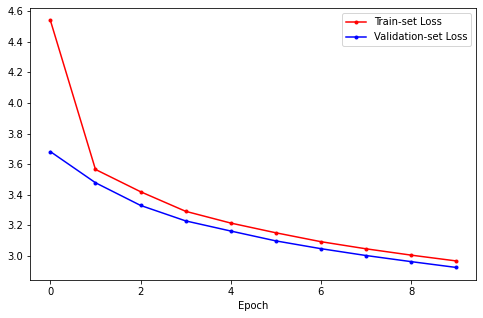

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(history.history['loss'], marker='.', c='red', label='Train-set Loss')
plt.plot(history.history['val_loss'], marker='.', c='blue', label='Validation-set Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# 세번째

In [75]:
history = model.fit(x = enc_train, y = dec_train, epochs=10, batch_size=512, validation_data = (enc_val_val, dec_val_val))

Epoch 1/10
158/158 [==============================] - 97s 615ms/step - loss: 2.5612 - val_loss: 2.4876
Epoch 2/10
158/158 [==============================] - 98s 621ms/step - loss: 2.5083 - val_loss: 2.4380
Epoch 3/10
158/158 [==============================] - 98s 620ms/step - loss: 2.4594 - val_loss: 2.3927
Epoch 4/10
158/158 [==============================] - 98s 622ms/step - loss: 2.4140 - val_loss: 2.3476
Epoch 5/10
158/158 [==============================] - 98s 620ms/step - loss: 2.3701 - val_loss: 2.3045
Epoch 6/10
158/158 [==============================] - 98s 621ms/step - loss: 2.3287 - val_loss: 2.2636
Epoch 7/10
158/158 [==============================] - 98s 622ms/step - loss: 2.2893 - val_loss: 2.2248
Epoch 8/10
158/158 [==============================] - 98s 620ms/step - loss: 2.2510 - val_loss: 2.1867
Epoch 9/10
158/158 [==============================] - 98s 621ms/step - loss: 2.2147 - val_loss: 2.1512
Epoch 10/10
158/158 [==============================] - 98s 620ms/step - l

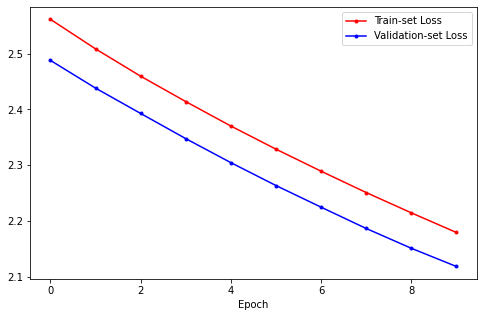

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(history.history['loss'], marker='.', c='red', label='Train-set Loss')
plt.plot(history.history['val_loss'], marker='.', c='blue', label='Validation-set Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# 두번째

In [74]:
history = model.fit(x = enc_train, y = dec_train, epochs=10, batch_size=256, validation_data = (enc_val_val, dec_val_val))

Epoch 1/10
315/315 [==============================] - 109s 337ms/step - loss: 4.3719 - val_loss: 3.3361
Epoch 2/10
315/315 [==============================] - 106s 335ms/step - loss: 3.2890 - val_loss: 3.1342
Epoch 3/10
315/315 [==============================] - 106s 338ms/step - loss: 3.1216 - val_loss: 3.0146
Epoch 4/10
315/315 [==============================] - 106s 337ms/step - loss: 3.0158 - val_loss: 2.9223
Epoch 5/10
315/315 [==============================] - 105s 334ms/step - loss: 2.9189 - val_loss: 2.8461
Epoch 6/10
315/315 [==============================] - 105s 333ms/step - loss: 2.8426 - val_loss: 2.7744
Epoch 7/10
315/315 [==============================] - 106s 336ms/step - loss: 2.7817 - val_loss: 2.7122
Epoch 8/10
315/315 [==============================] - 105s 333ms/step - loss: 2.7201 - val_loss: 2.6531
Epoch 9/10
315/315 [==============================] - 106s 335ms/step - loss: 2.6678 - val_loss: 2.5972
Epoch 10/10
315/315 [==============================] - 106s 335m

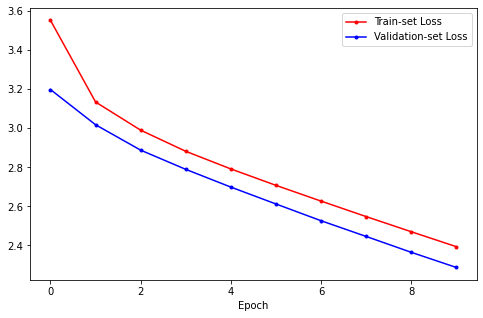

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(history.history['loss'], marker='.', c='red', label='Train-set Loss')
plt.plot(history.history['val_loss'], marker='.', c='blue', label='Validation-set Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# 첫번째 시도
## 문장 정제를 어떻게 하느냐에 따라 parameter의 총량이 달라졌다.
## 이때의 loss, val_loss 값들은 문장 수를 30개 이하으로 정제 했을때 나온 값들이다.

In [21]:
history = model.fit(x = enc_train, y = dec_train, epochs=10, batch_size=128, validation_data = (enc_val_val, dec_val_val))

Epoch 1/10
456/456 [==============================] - 84s 185ms/step - loss: 1.2970 - val_loss: 1.2310
Epoch 2/10
456/456 [==============================] - 85s 186ms/step - loss: 1.2471 - val_loss: 1.1824
Epoch 3/10
456/456 [==============================] - 85s 187ms/step - loss: 1.2012 - val_loss: 1.1420
Epoch 4/10
456/456 [==============================] - 85s 187ms/step - loss: 1.1591 - val_loss: 1.1003
Epoch 5/10
456/456 [==============================] - 85s 187ms/step - loss: 1.1197 - val_loss: 1.0632
Epoch 6/10
456/456 [==============================] - 85s 187ms/step - loss: 1.0836 - val_loss: 1.0278
Epoch 7/10
456/456 [==============================] - 85s 187ms/step - loss: 1.0500 - val_loss: 0.9986
Epoch 8/10
456/456 [==============================] - 85s 187ms/step - loss: 1.0190 - val_loss: 0.9692
Epoch 9/10
456/456 [==============================] - 85s 187ms/step - loss: 0.9911 - val_loss: 0.9419
Epoch 10/10
456/456 [==============================] - 85s 187ms/step - l

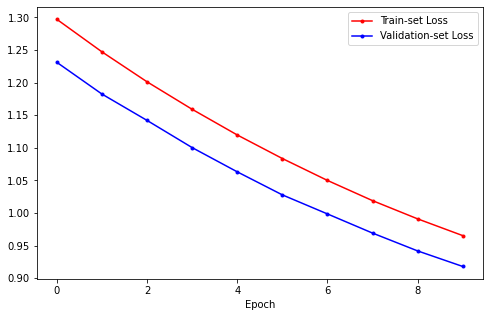

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(history.history['loss'], marker='.', c='red', label='Train-set Loss')
plt.plot(history.history['val_loss'], marker='.', c='blue', label='Validation-set Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## 시각적으로 봤을 때loss와 val_loss의 값은 차이가 거의 일정하게 나고 epochs당 잘 줄어들었다.

In [23]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=15):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [24]:
generate_text(model, tokenizer, init_sentence="<start> life")

'<start> life is a marathon <end> '

In [25]:
generate_text(model, tokenizer, init_sentence="<start> kill")

'<start> kill the lights ! <end> '

In [26]:
generate_text(model, tokenizer, init_sentence="<start> cut")

'<start> cut me , cut u <end> '

In [28]:
generate_text(model, tokenizer, init_sentence="<start> time")

'<start> time time for you to die <end> '

In [29]:
generate_text(model, tokenizer, init_sentence="<start> smoke")

'<start> smoke barney and baby bop <end> '

*********
# 회고


- 문제 1. : 문장 수를 15단어 이하로 제한하지 않았기 때문에 첫 시도에서 하나의 epochs 당 1시간이 걸려, 10시간동안 돌리다가 커널과 연결이 끊겨서 결과 확인 불가
#### 이 문제는 문장 수의 제한이 없기 때문에 0 값이 많아져서 오래 걸렸다.


- 문제 2. : train, test로 나눠 RNN을 통해 학습을 시키기까지 시간이 너무 오래 걸렸다. (총 4개의 데이터로 나누는 것을 알게 될때까지 많은 블로그와 많은 사람들의 도움을 받았다.)


- 문제 3. 글자 수를 30단어로 정제 했을때와 15단어로 정제 했을때 epochs 값이 다르고 loss값도 다르다.(왜 그런지 모르겠다.)

- 문제 4. model(src_sample)을 했을때 Trace back의 오류가 많이 생겨 초기화를 하는데, 시간을 많이 사용했다. (학습시키는데도 시간이 오래 걸리기 때문에 이번에는 여러 시도를 해보지 못했다.)

### 생긴 오류
- 배치 사이즈에 따른 GPU 메모리 부족 오류
- 커널이 죽어버리는 오류


*******************

- 배치 사이즈를 달리 했을때 에포치의 비교하는 숫자가 달라짐 작아질수록 커진다.

- **단어 제한**에 따라 생성되는 문장들이 다르고, 단어장에 없는 단어를 넣었을 때는 결과가 나오지 않았다.
- 학습 시킬때마다 같은 문장을 입력해도 다른 문장이 출력 된다.

- 이상한 것은 연속해서 배치 사이즈를 키우며 학습을 시켰을때 loss 값이 줄어들었고, 초기화 후 가장 loss값이 적은 결과로 다시 봤을때는 오히려 커져 있었다.

- 그 결과 정확히 loss를 줄이는 방법은 더 많이 시도해봐야 알 것 같다.
- 확실한것은 **배치 사이즈가 커질수록 학습 시간은 줄어든다.**(여러번 학습을 하게 되기 때문에??? 갈수록 높아지는거 같다.) 